In [35]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%%capture
# using capture we can hide output of a cell
import os
for dirname, _, filename in os.walk("/content/gdrive/My Drive/Datasets/Plant Diseases/Plant Pathology 2020"):
  for files in filename:
    print(os.path.join(dirname, files))


# IMAGE PRE-PROCESSING

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cv2
from tqdm import tqdm_notebook as tqdm
from collections import deque

In [0]:
train_data = pd.DataFrame(pd.read_csv("/content/gdrive/My Drive/Datasets/Plant Diseases/Plant Pathology 2020/train.csv"))
test_data = pd.DataFrame(pd.read_csv("/content/gdrive/My Drive/Datasets/Plant Diseases/Plant Pathology 2020/test.csv"))

In [39]:
print("Training data shape : = {}".format(train_data.shape))
print("Test data shape : = {}".format(test_data.shape))

Training data shape : = (1821, 5)
Test data shape : = (1821, 1)


In [40]:
train_data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [41]:
test_data.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [0]:
image_folder_path = "/content/gdrive/My Drive/Datasets/Plant Diseases/Plant Pathology 2020/images/"

In [0]:
arr = train_data["image_id"]
train_images = [i for i in arr]  

arr = test_data["image_id"]
test_images = [i for i in arr]

In [44]:
print("Number of training images = {}".format(len(train_images)))
print("Number of test images = {}".format(len(test_images)))

Number of training images = 1821
Number of test images = 1821


In [0]:
def load_image(image_id) : 
  image_path = image_folder_path +image_id +".jpg"
  image = cv2.imread(image_path) 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

An image is essentially a numpy array of values. To bring all the images to one same dimensions(that is a 3D tensor) we resize them.

In [0]:
def resize(image):
  image = cv2.resize(image, (800, 800))
  return image

In [0]:
#train_images = [load_image(i) for i in tqdm(train_images[: 1000])]

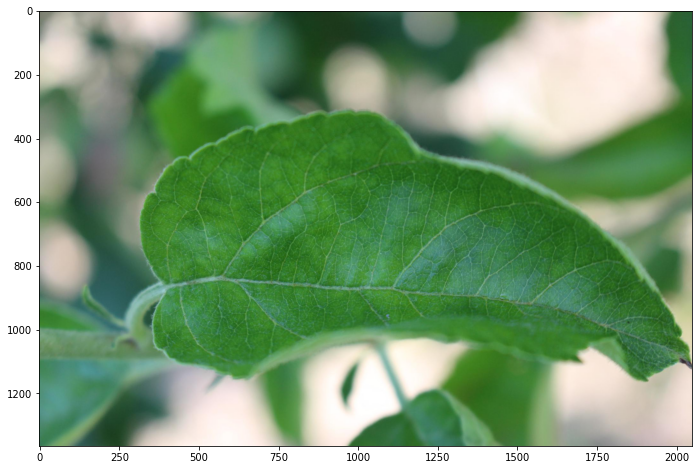

In [48]:
sample_image = load_image(train_images[2])
plt.figure(figsize = (12, 8))
plt.grid(False)
plt.imshow(sample_image, cmap = "gray")

In [0]:
def gaussian_blur(image):
  filtered_image = cv2.GaussianBlur(image, (5,5), 0)
  return filtered_image

#### Edge Detection : 

Edge detection is one of the fundamental operation in image processing. Using this, we can reduce the amount of pixels while maintaining the structural aspect of the images. This can be done using :


*   First derivative based Sobel filter(for thicker edges)
*   Second derivative based Laplacian filter(for finer edges)

Here, we want to consider the area containing only the leaf, while ignoring the background green. Hence, we use Sobel filter to identify the prominent edge of the leaf.

In [0]:
def sobel_edge_detection(image):
  """
  Using Sobel filter

  Sobel filter takes the following arguments : 
  1. Original Image
  2. Depth of the destination image
  3. Order of derivative x
  4. Order of derivative y
  5. Kernel size for convolutions

  f(Image, depth, order_dx, order_dy, kernel_size) 
  """
  sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = 5)
  sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = 5)
  return sobel_x, sobel_y


In [0]:
# sample_image
f_img = gaussian_blur(sample_image)
s_img_x, s_img_y = sobel_edge_detection(sample_image)

Visualizing the output of our functions with a sample image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2047.5, 1364.5, -0.5)

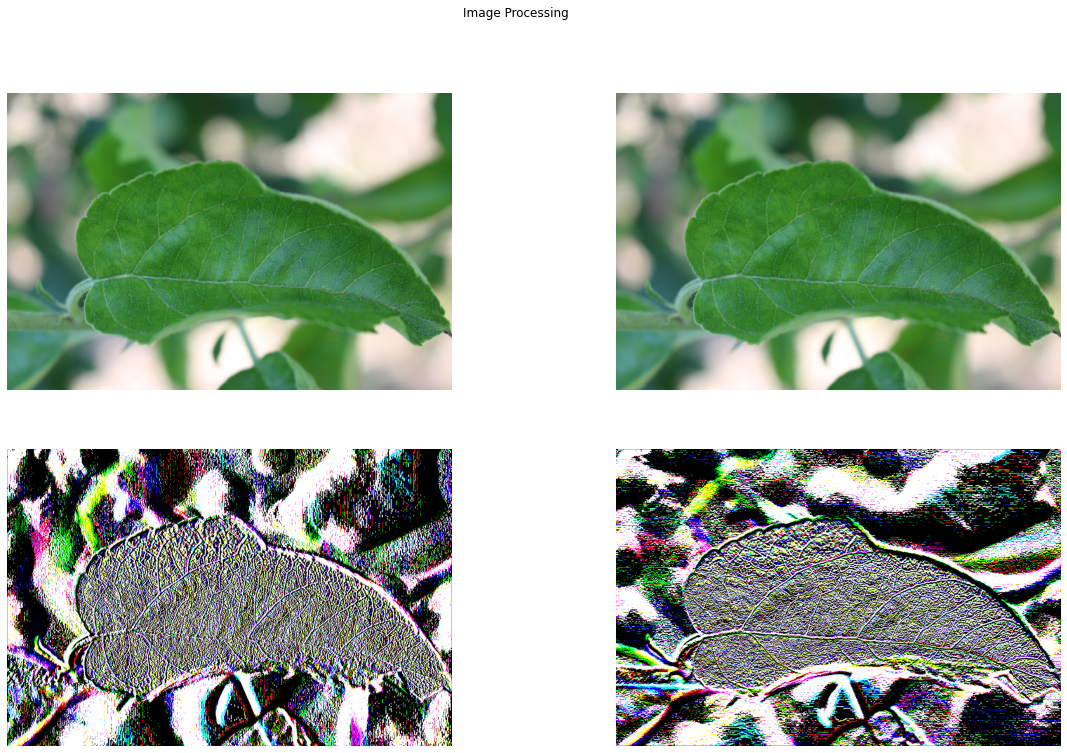

In [52]:
fig, axs= plt.subplots(2,2, figsize = (20, 12))
fig.suptitle("Image Processing")
axs[0,0].imshow(sample_image, cmap = "gray")
axs[0,0].axis(False)
axs[0,1].imshow(f_img, cmap = "gray")
axs[0,1].axis(False)
axs[1,0].imshow(s_img_x, cmap = "gray")
axs[1,0].axis(False)
axs[1,1].imshow(s_img_y, cmap = "gray")
axs[1,1].axis(False)

Using sobel filter we found the edges, however for further pre-processing we aim to consider only the area of the leaf, that is the fine textured area we see in the gradient images. For that, we will use a much powerful inbuilt function of open-CV called Canny(). This function will return the edge coordinates.

Entire read is available on the OpenCV webpage : 

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html#canny 

In [0]:
def canny_edge_detection(image):
  edges = cv2.Canny(image, 100, 200) 
  return edges

def primary_roi(original_image, edge_image):
  edge_coordinates = deque()
  for i in tqdm(range(edge_image.shape[0])):
    for j in range(edge_image.shape[1]):
      if edge_image[i][j] != 0 :
        edge_coordinates.append((i, j))
  
  min_row = edge_coordinates[np.argsort([coordinate[0] for coordinate in edge_coordinates])[0]][0]
  max_row = edge_coordinates[np.argsort([coordinate[0] for coordinate in edge_coordinates])[-1]][0]
  min_col = edge_coordinates[np.argsort([coordinate[1] for coordinate in edge_coordinates])[0]][1]
  max_col = edge_coordinates[np.argsort([coordinate[1] for coordinate in edge_coordinates])[-1]][1]
  new_image = original_image.copy()
  new_image[min_row - 10 : min_row + 10, min_col : max_col] = [255, 0, 0]
  new_image[max_row - 10 : max_row + 10, min_col : max_col] = [255, 0, 0]
  new_image[min_row : max_row , min_col - 10 : min_col + 10] = [255, 0, 0]
  new_image[min_row : max_row , max_col - 10 : max_col + 10] = [255, 0, 0]

  roi_image = new_image[min_row : max_row, min_col : max_col]
  
  return new_image, roi_image

(-0.5, 2047.5, 1364.5, -0.5)

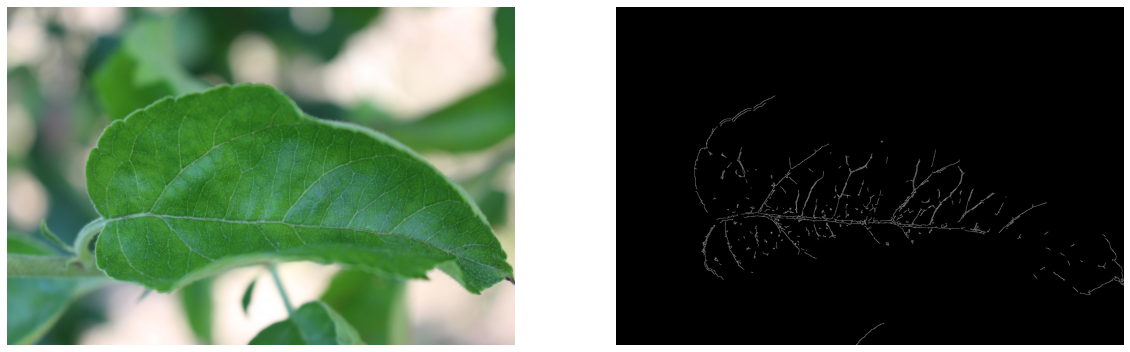

In [54]:
fig, axs= plt.subplots(1,2 , figsize = (20, 12))
axs[0].imshow(sample_image, cmap = "gray")
axs[0].axis(False)

edge_image = canny_edge_detection(sample_image) 
axs[1].imshow(edge_image, cmap = "gray")
axs[1].axis(False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


(-0.5, 1730.5, 1002.5, -0.5)

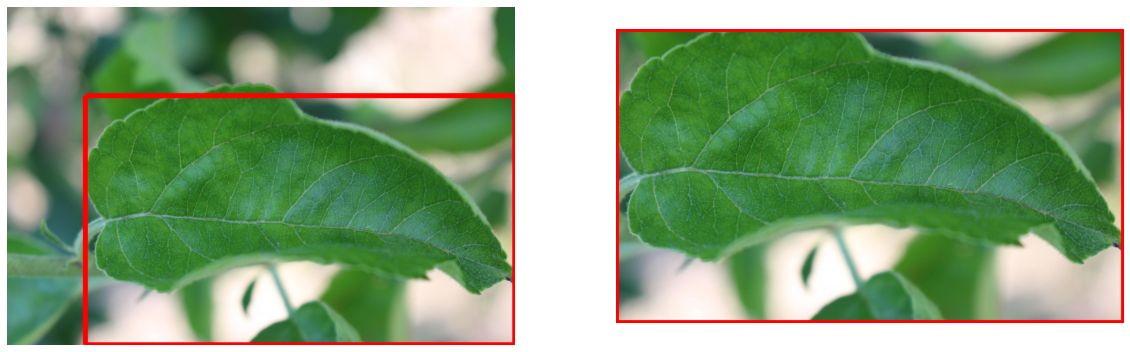

In [55]:
new_image, roi_image = primary_roi(sample_image, edge_image)

fig, axs= plt.subplots(1,2 , figsize = (20, 12))
axs[0].imshow(new_image, cmap = "gray")
axs[0].axis(False)

axs[1].imshow(roi_image, cmap = "gray")
axs[1].axis(False)

## Histogram Equalization in ROI section of the whole image
### First of all, why can we not apply histogram equalization directly to an RGB image?

Histogram equalization is a non-linear process. Channel splitting and equalizing each channel separately is incorrect. Equalization involves intensity values of the image, not the color components. So for a simple RGB color image, histogram equalization cannot be applied directly on the channels. It needs to be applied in such a way that the intensity values are equalized without disturbing the color balance of the image. So, the first step is to convert the color space of the image from RGB into one of the color spaces that separates intensity values from color components. Some of the possible options are HSV/HLS, YUV, YCbCr, etc. YCbCr is preferred as it is designed for digital images. Perform histogram equalization on the intensity plane Y. Now convert the resultant YCbCr image back to RGB.

(Excerpt taken from : 

https://prateekvjoshi.com/2013/11/22/histogram-equalization-of-rgb-images/ )

In [56]:
"""
def preprocessed_images(): 
  preprocessed_images = deque()
  for i in tqdm(train_data["image_id"]):
    image = load_image(i)
    edge_image = canny_edge_detection(image)
    _ , roi_image = primary_roi(image, edge_image)
  return preprocessed_images
"""

'\ndef preprocessed_images(): \n  preprocessed_images = deque()\n  for i in tqdm(train_data["image_id"]):\n    image = load_image(i)\n    edge_image = canny_edge_detection(image)\n    _ , roi_image = primary_roi(image, edge_image)\n  return preprocessed_images\n'